## Загрузка датасета

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [38]:
path = "../datasets/teen_phone_addiction_dataset.csv"

df = pd.read_csv(path)
print(df.shape)

(3000, 25)


In [4]:
df.head()

,ID,Name,Age,Gender,Location,School_Grade,Daily_Usage_Hours,Sleep_Hours,Academic_Performance,Social_Interactions,...,Screen_Time_Before_Bed,Phone_Checks_Per_Day,Apps_Used_Daily,Time_on_Social_Media,Time_on_Gaming,Time_on_Education,Phone_Usage_Purpose,Family_Communication,Weekend_Usage_Hours,Addiction_Level
0,1,Shannon Francis,13,Female,Hansonfort,9th,4.0,6.1,78,5,...,1.4,86,19,3.6,1.7,1.2,Browsing,4,8.7,10.0
1,2,Scott Rodriguez,17,Female,Theodorefort,7th,5.5,6.5,70,5,...,0.9,96,9,1.1,4.0,1.8,Browsing,2,5.3,10.0
2,3,Adrian Knox,13,Other,Lindseystad,11th,5.8,5.5,93,8,...,0.5,137,8,0.3,1.5,0.4,Education,6,5.7,9.2
3,4,Brittany Hamilton,18,Female,West Anthony,12th,3.1,3.9,78,8,...,1.4,128,7,3.1,1.6,0.8,Social Media,8,3.0,9.8
4,5,Steven Smith,14,Other,Port Lindsaystad,9th,2.5,6.7,56,4,...,1.0,96,20,2.6,0.9,1.1,Gaming,10,3.7,8.6


In [5]:
N = 2
cols = ['Daily_Usage_Hours', 'Sleep_Hours', 'Exercise_Hours', 'Screen_Time_Before_Bed', 'Time_on_Social_Media', 'Time_on_Gaming', 'Time_on_Education']
col_name = cols[N % 7]
print(col_name)

Exercise_Hours


## 1. Рассчет характеристик

Среднее: 1.04067
Дисперсия (выборочная): 0.539666
Мода(ы): [0.]
Медиана: 1
Квантили 0.25, 0.5, 0.75: 0.5, 1, 1.5
Эксцесс (Fisher): -0.257488
Ассиметрия: 0.438639
Интерквартильный размах (IQR): 1


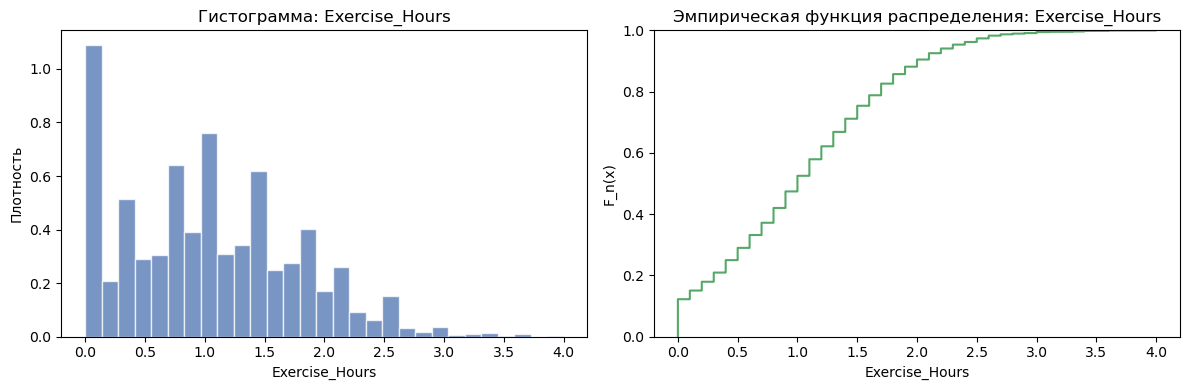

In [57]:
def calculate_statistics(s):
    mean_val = s.mean()
    var_val = s.var(ddof=1)               
    median_val = s.median()
    quartiles = s.quantile([0.25, 0.5, 0.75])
    q25, q50, q75 = quartiles.loc[0.25], quartiles.loc[0.5], quartiles.loc[0.75]
    iqr = q75 - q25
    
    mode_vals = s.mode().values
    
    skewness = stats.skew(s, bias=False, nan_policy="omit")
    kurtosis_excess = stats.kurtosis(s, fisher=True, bias=False, nan_policy="omit")
    
    print(f"Среднее: {mean_val:.6g}")
    print(f"Дисперсия (выборочная): {var_val:.6g}")
    print("Мода(ы):", mode_vals)
    print(f"Медиана: {median_val:.6g}")
    print(f"Квантили 0.25, 0.5, 0.75: {q25:.6g}, {q50:.6g}, {q75:.6g}")
    print(f"Эксцесс (Fisher): {kurtosis_excess:.6g}")
    print(f"Ассиметрия: {skewness:.6g}")
    print(f"Интерквартильный размах (IQR): {iqr:.6g}")

    # Графики
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # 1) Гистограмма + KDE
    axes[0].hist(s, bins="auto", color="#4C72B0", alpha=0.75, edgecolor="white", density=True)
    axes[0].set_title(f"Гистограмма: {col_name}")
    axes[0].set_xlabel(col_name)
    axes[0].set_ylabel("Плотность")
    
    # 2) Эмпирическая функция распределения (ECDF)
    x_sorted = np.sort(s.values)
    y = np.arange(1, len(x_sorted) + 1) / len(x_sorted)
    axes[1].step(x_sorted, y, where="post", color="#55A868")
    axes[1].set_title(f"Эмпирическая функция распределения: {col_name}")
    axes[1].set_xlabel(col_name)
    axes[1].set_ylabel("F_n(x)")
    axes[1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

col = df[col_name].dropna()  
calculate_statistics(col)

Распределение имеет отрицательный эксцесс, что говорит о том, что оно немного более плоское чем нормальное распределение. Также распределение имеет положительную ассиметрию, что говорит о том, что распределение смещено вправо. Хотя больше похоже на то, что значения справа являются выбросами.

## 2. Проверка данных на нормальность

Статистика хи-квадрат: 765.1587268998566
Нулевая гипотеза о нормальности данных отвергается.
Асимметрия: 0.43841915278918886
Эксцесс: -0.2590583883822495


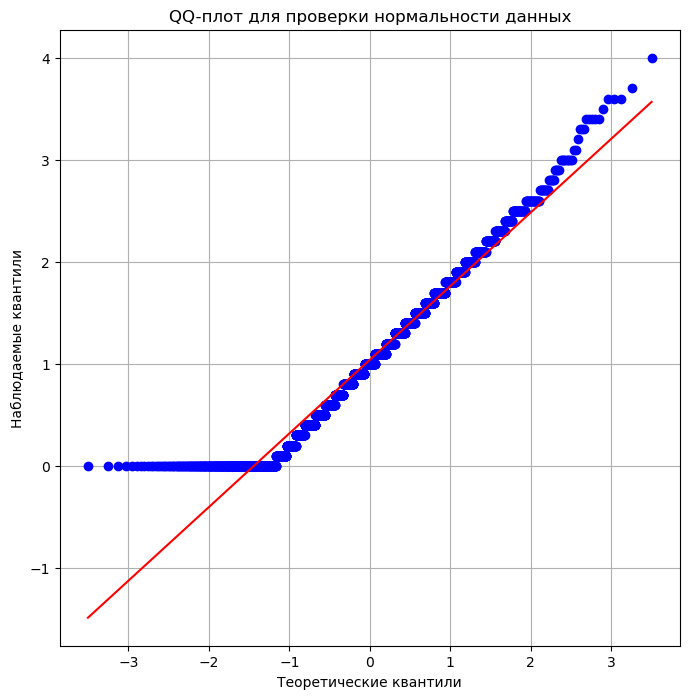

In [44]:
from scipy.special import erf

def check_normality(data_column):
    data = data_column.values;

    num_bins = 10
    
    # Подсчет наблюдаемых частот
    min_value = np.min(data)
    max_value = np.max(data)
    bin_edges = np.linspace(min_value, max_value, num_bins + 1)
    observed_freq = np.zeros(num_bins)
    
    # Подсчет частот в каждом интервале
    for value in data:
        for i in range(num_bins):
            if bin_edges[i] <= value < bin_edges[i + 1]:
                observed_freq[i] += 1
                break
    
    # Вычисляем параметры нормального распределения
    mean = np.mean(data)
    std_dev = np.std(data)
    
    # Вычисляем ожидаемые частоты
    expected_freq = np.zeros(num_bins)
    total_count = len(data)
    
    for i in range(num_bins):
        # Ширина интервала
        bin_width = bin_edges[i + 1] - bin_edges[i]
        # Вычисляем ожидаемую частоту для каждого интервала
        expected_freq[i] = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((bin_edges[i] - mean) / std_dev) ** 2) * total_count * bin_width
    
    # Убедитесь, что суммы наблюдаемых и ожидаемых частот совпадают
    if np.sum(observed_freq) != np.sum(expected_freq):
        scaling_factor = np.sum(observed_freq) / np.sum(expected_freq)
        expected_freq *= scaling_factor
    
    # Применяем критерий хи-квадрат вручную
    chi2_stat = 0
    for o, e in zip(observed_freq, expected_freq):
        if e > 0:  # Избегаем деления на ноль
            chi2_stat += (o - e) ** 2 / e
    
    # Вывод результатов
    print(f"Статистика хи-квадрат: {chi2_stat}")
    
    # Интерпретация результата
    critical_value = 14.067  # Критическое значение для 7 степеней свободы и α = 0.05
    if chi2_stat > critical_value:
        print("Нулевая гипотеза о нормальности данных отвергается.")
    else:
        print("Нет оснований отвергать нулевую гипотезу о нормальности данных.")
    
    skewness_value = stats.skew(data)
    kurtosis_value = stats.kurtosis(data)
    print(f"Асимметрия: {skewness_value}")
    print(f"Эксцесс: {kurtosis_value}")

    plt.figure(figsize=(8, 8))
    stats.probplot(data, dist="norm", plot=plt)
    plt.title('QQ-плот для проверки нормальности данных')
    plt.xlabel('Теоретические квантили')
    plt.ylabel('Наблюдаемые квантили')
    plt.grid()
    plt.show()

check_normality(col)

С учетом всех полученных результатов можно сделать вывод, что данные не следуют нормальному распределению. Высокое значение статистики хи-квадрат и соответствующее ему низкое p-значение убедительно свидетельствуют о том, что распределение данных значительно отличается от нормального. По QQ-плот видно, что распределение сильно отличается от нормального на концах.

## 3. Приведение данных к нормальному распределению

Среднее: 4.5212e-17
Дисперсия (выборочная): 1
Мода(ы): [-1.72141071]
Медиана: 0.139185
Квантили 0.25, 0.5, 0.75: -0.818228, 0.139185, 0.738163
Эксцесс (Fisher): -0.894425
Ассиметрия: -0.282898
Интерквартильный размах (IQR): 1.55639


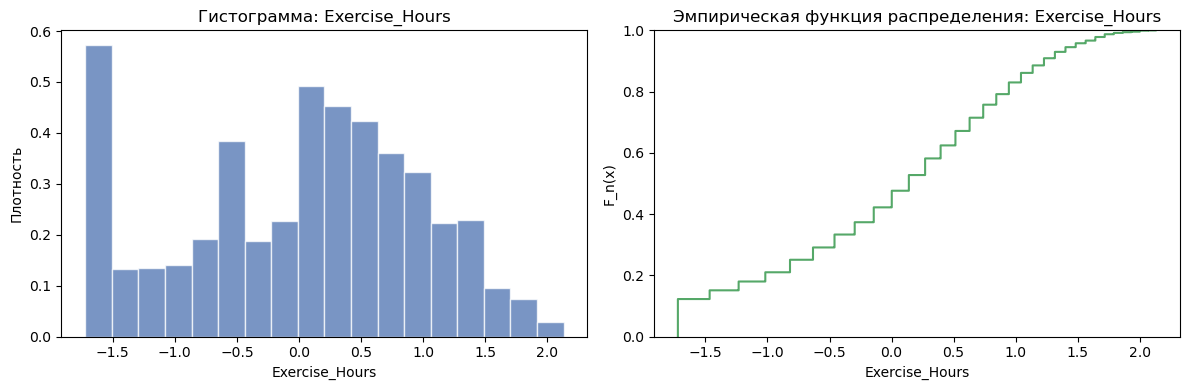

Статистика хи-квадрат: 1202.9723897052106
Нулевая гипотеза о нормальности данных отвергается.
Асимметрия: -0.2827555548922907
Эксцесс: -0.8949369334077231


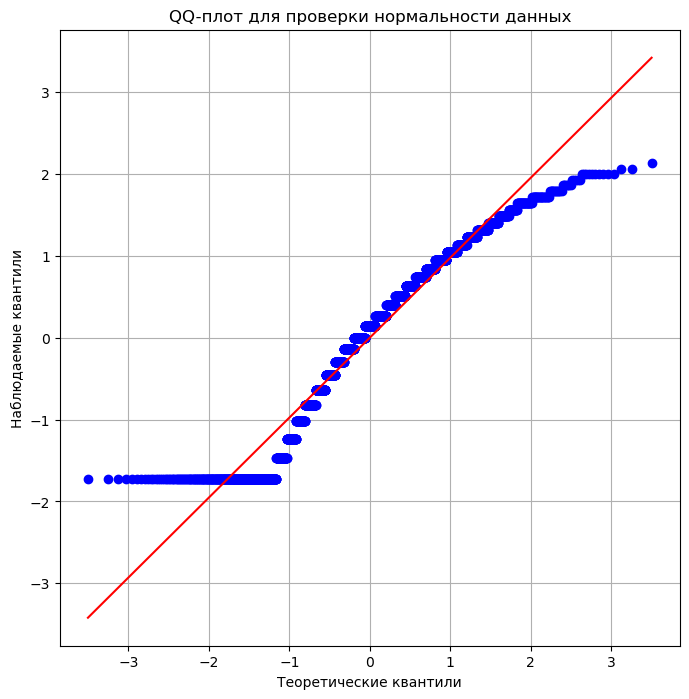

In [13]:
def transform_to_normal(df_column):
    z_scores = np.abs(stats.zscore(df_column))
    filtered_column = df_column[z_scores < 3]  # Удаляем выбросы, Z > 3
    
    log_transformed = np.log(filtered_column + 1)
    
    standardized = (log_transformed - log_transformed.mean()) / log_transformed.std()
    
    return standardized

col_norm = transform_to_normal(col.copy())
calculate_statistics(col_norm)
check_normality(col_norm)

После нормализации среднее стало равно 0, а дисперсия 1. Также теперь ассиметрия стала отрицательной, это связано с тем, что были удалены выбросы справа и теперь распределние скошено влево. Статистика хи-квадрат стала больше, следовательно привести данные к нормальному распределению не удалось.

## 4. Группировка данных

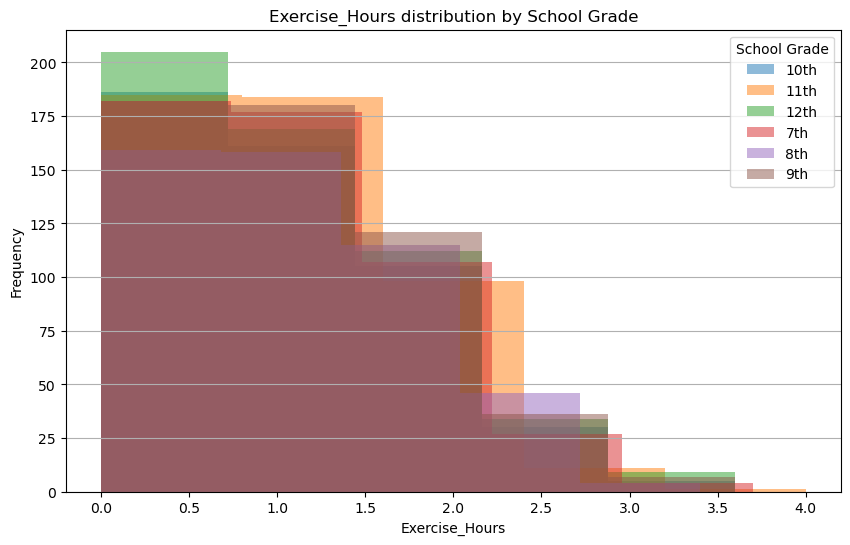

  School_Grade      mean       var
0         10th  1.042505  0.536523
1         11th  0.979541  0.486652
2         12th  1.045936  0.564155
3          7th  1.029577  0.532410
4          8th  1.062033  0.551674
5          9th  1.080228  0.561665


In [15]:
grouped = df.groupby('School_Grade')

# Создание фигуры для гистограмм
plt.figure(figsize=(10, 6))

# Построение гистограмм для каждой группы
for name, group in grouped:
    plt.hist(group[col_name], alpha=0.5, label=name, bins=5)

# Добавление меток и легенды
plt.title(f'{col_name} distribution by School Grade')
plt.xlabel(col_name)
plt.ylabel('Frequency')
plt.legend(title='School Grade')
plt.grid(axis='y')

# Показать график
plt.show()

# Расчет среднего и дисперсии внутри каждой группы
mean_variance = grouped[col_name].agg(['mean', 'var']).reset_index()
print(mean_variance)

In [26]:
mean_variance

,School_Grade,mean,var
0,10th,1.042505,0.536523
1,11th,0.979541,0.486652
2,12th,1.045936,0.564155
3,7th,1.029577,0.532410
4,8th,1.062033,0.551674
5,9th,1.080228,0.561665


Для 8-9, 10, 12 классов значения среднего и дисперсии лишь немного отличаются, что говорит о схожести распределений. Небольшое отличие есть лишь для 10 класса, в котором среднее количество часов уменьшается и немного уменьшается дисперсия. Также для 12 класса сильно увеличивается число учеников, которые уделяют обучению 0-0.5 часов.